# Data Pre-processing and Exploratory Data Analysis for NYC Trip Records Dataset
Our goal in this project is to forecast hourly commercial transportation demand for taxi zones in New York City. For this goal, we plan on making use of the NYC Taxi and Limousine Commission (TLC) Trip Record Data and Hourly weather records taken on New York City. For now, we do not have access to weather data in hourly resolution. Therefore we made our analysis and exploration on NYC Yellow Taxi Records for the year (2023). To this end, our goal as a first step is to load the NYC trip records and do basic exploratory data analysis to determine the required pre-processing steps. For this, we first loaded the trip records into pandas data frames. Examined the individual trip records to look for faulty records to obtain a reliable dataset develop our models.

To use in the models we develop, we aim to have the dataset with the following features:
| Location ID | Hour | Day of week | Day of Year | Month | Quarter | Temperature | Wind | Humidity | Air quality | Demand |
| -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| int{1-265} | int{0-23} | int{0-6} | int{0-364} | int{0-12} | int{0-3} | float64 | float64 | float64 | float64 | int |

### Examination of the raw dataset:

In [7]:
import os, sys
from pathlib import Path

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd


BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
YELLOW_DIR = DATA_DIR / 'yellow_taxi_trip_records'
GREEN_DIR = DATA_DIR / 'green_taxi_trip_records'
FHV_DIR = DATA_DIR / 'for_hire_vehicle_trip_records'

def load_monthly_trip_data(start_month, end_month=None, dataset='yellow', drop_other_columns=False):
    """Load the yellow taxi trip data for the specified month(s)

    Parameters
    ----------
    start_month : str
        The start month in 'YYYY-MM' format
    end_month : str, optional
        The end month in 'YYYY-MM' format. If not specified, only the start month will be loaded
    dataset: str, optional
        The dataset to load. Default is 'yellow'. Other options are 'green' and 'for_hire'

    Returns
    -------
    list of pandas.DataFrame
        A list of DataFrames containing the trip data for each month
    """
    if end_month is None:
        end_month = start_month
    
    if dataset == 'yellow':
        dataset_path = YELLOW_DIR
    elif dataset == 'green':
        dataset_path = GREEN_DIR
    elif dataset == 'for_hire':
        dataset_path = FHV_DIR
    else:
        raise ValueError("Invalid dataset. Please specify 'yellow', 'green', or 'for_hire'")
    
    if not dataset_path.exists():
        raise FileNotFoundError(f"Directory for '{dataset}' is not found in {dataset_path}")
    
    if drop_other_columns:
        columns = ['tpep_pickup_datetime','tpep_dropoff_datetime','PULocationID','DOLocationID']
    else:
        columns = None

    dates = pd.date_range(start_month, end_month, freq='MS')
    months = [date.strftime('%Y-%m') for date in dates]
    monthly_trip_records = [pd.read_parquet(dataset_path / f'yellow_tripdata_{month}.parquet',
                                            columns=columns)
                            for month in months]
    return monthly_trip_records

In [10]:
raw_monthly_trip_datasets = load_monthly_trip_data('2023-01', '2023-12', 'yellow')
print("Month 2019-01 Records:\n ------------------------------------ \n")
raw_monthly_trip_datasets[0].head()
raw_monthly_trip_datasets[0].info()


Month 2019-01 Records:
 ------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  co

The trip records include 19 records which can be seen above. Among these, we are primarily interested in the `tpep_pickup_datetime` and `PULocationID` which respectively encode the time stamp of the start of the trip and the pick up location. However, with the use of `tpep_dropoff_datetime`, we can look for anomalous entries within the records that contain logical errors.

Per our analysis, the records are not perfect and have the following issues,
- Pick-up and drop-off time stamps of the trips are faulty. 
    - **Issue 1:**

        Trips recorded under a specific months record whose time stamps indicate other months/years. Mostly next/previous hour from end or beginning of the month.
    - **Issue 2:**

        Trip records with pick up time stamp later than or equal to the drop-off time stamp.

### Examples:
- **Issue 1:**

In [267]:
month_begin_ts = pd.Timestamp('2023-01')
next_month_ts = month_begin_ts + pd.offsets.MonthBegin()
raw_monthly_trip_datasets[0][raw_monthly_trip_datasets[0]['tpep_pickup_datetime'] < month_begin_ts].head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
80,2,2022-12-31 23:51:30,2022-12-31 23:56:06,1.0,0.86,1.0,N,141,140,1,6.5,1.0,0.5,2.00,0.0,1.0,13.50,2.5,0.0
567,2,2022-12-31 23:59:37,2023-01-01 00:07:28,1.0,2.38,1.0,N,142,151,1,12.1,1.0,0.5,4.28,0.0,1.0,21.38,2.5,0.0
761,2,2022-12-31 23:58:27,2023-01-01 00:02:21,1.0,0.49,1.0,N,229,237,1,5.8,1.0,0.5,0.08,0.0,1.0,10.88,2.5,0.0
900,2,2022-12-31 23:44:31,2022-12-31 23:48:47,1.0,0.52,1.0,N,233,162,1,5.8,1.0,0.5,2.16,0.0,1.0,12.96,2.5,0.0
1177,2,2022-12-31 23:59:25,2023-01-01 00:19:21,2.0,3.65,1.0,N,141,68,1,19.1,1.0,0.5,7.23,0.0,1.0,31.33,2.5,0.0


- **Issue 2:**

In [269]:
raw_monthly_trip_datasets[0][raw_monthly_trip_datasets[0]['tpep_pickup_datetime'] >=  raw_monthly_trip_datasets[0]['tpep_dropoff_datetime']].head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
3291,1,2023-01-01 00:11:55,2023-01-01 00:11:55,1.0,0.0,5.0,Y,137,264,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4971,1,2023-01-01 01:54:01,2023-01-01 01:54:01,1.0,0.0,1.0,N,237,264,2,3.0,3.5,0.5,0.0,0.0,1.0,8.0,2.5,0.0
11648,1,2023-01-01 02:45:08,2023-01-01 02:45:08,1.0,0.0,1.0,N,234,264,2,3.0,3.5,0.5,0.0,0.0,1.0,8.0,2.5,0.0
15664,1,2023-01-01 03:55:38,2023-01-01 03:55:38,1.0,0.0,1.0,N,48,264,2,3.0,3.5,0.5,0.0,0.0,1.0,8.0,2.5,0.0
22644,1,2023-01-01 07:24:56,2023-01-01 07:24:56,1.0,0.0,1.0,Y,116,264,2,10.7,2.5,0.5,0.0,0.0,1.0,14.7,0.0,0.0


In [54]:
def detect_faulty_records_in_monthly_record(month_record, month, only_stats=False):
    """Detect records with faulty time-stamps in the monthly trip record
    
    Detect records with the following issues:
    1. Drop-off time earlier than or equal to the pick-up time
    2. Pick-up time earlier than the begining of the month
    3. Pick-up time later than end of the month
    Parameters:
    month_record : pandas.DataFrame
        The monthly trip record
    month : str
        The month in 'YYYY-MM' format

    """
    month_begin_ts = pd.Timestamp(month)
    next_month_ts = month_begin_ts + pd.offsets.MonthBegin()

    early_rows = month_record['tpep_pickup_datetime'] < month_begin_ts
    late_rows = month_record['tpep_pickup_datetime'] >= next_month_ts
    pu_lateroe_than_do = month_record['tpep_pickup_datetime'] >= month_record['tpep_dropoff_datetime']
    pul_nan = month_record['PULocationID'].isnull()
    do_nan = month_record['DOLocationID'].isnull()
    if only_stats:
        return sum(early_rows), sum(late_rows), sum(pu_lateroe_than_do), sum(pul_nan), sum(do_nan)
    else:
        return early_rows, late_rows, pu_lateroe_than_do, pul_nan, do_nan

start_month = '2023-01'
end_month = '2023-12'
dates = pd.date_range(start_month, end_month, freq='MS')
months = [date.strftime('%Y-%m') for date in dates]
for i, month in enumerate(months):
    print(f"-------------------------\n Checking month {month}\n-------------------------")
    stats = detect_faulty_records_in_monthly_record(raw_monthly_trip_datasets[i], month, only_stats=True)
    print(f"Pick-up earlier than month start: {stats[0]}/{raw_monthly_trip_datasets[i].shape[0]} = {stats[0]/raw_monthly_trip_datasets[i].shape[0]:.4%}")
    print(f"Pick-up later than month end: {stats[1]}/{raw_monthly_trip_datasets[i].shape[0]} = {stats[1]/raw_monthly_trip_datasets[i].shape[0]:.4%}")
    print(f"Pick-up later than or equal to the drop-off: {stats[2]}/{raw_monthly_trip_datasets[i].shape[0]} = {stats[2]/raw_monthly_trip_datasets[i].shape[0]:.4%}")
    print("Null Pick-up Locations: ", stats[3])
    print("Null Drop-off Locations: ", stats[4])

-------------------------
 Checking month 2023-01
-------------------------
Pick-up earlier than month start: 38/3066766 = 0.0012%
Pick-up later than month end: 10/3066766 = 0.0003%
Pick-up later than or equal to the drop-off: 1121/3066766 = 0.0366%
Null Pick-up Locations:  0
Null Drop-off Locations:  0
-------------------------
 Checking month 2023-02
-------------------------
Pick-up earlier than month start: 13/2913955 = 0.0004%
Pick-up later than month end: 42/2913955 = 0.0014%
Pick-up later than or equal to the drop-off: 1265/2913955 = 0.0434%
Null Pick-up Locations:  0
Null Drop-off Locations:  0
-------------------------
 Checking month 2023-03
-------------------------
Pick-up earlier than month start: 104/3403766 = 0.0031%
Pick-up later than month end: 85/3403766 = 0.0025%
Pick-up later than or equal to the drop-off: 1453/3403766 = 0.0427%
Null Pick-up Locations:  0
Null Drop-off Locations:  0
-------------------------
 Checking month 2023-04
-------------------------
Pick-up 

# Pre-processing: 
Since these records are very rare and we have a large number of trip records, we chose to discard those trip records that exhibit *Issue 1* or *Issue 2*. We discretize the date range into hourly periods and count the number of trip records for every taxi zone. For every hour, we create new features `dayofweek`, `dayofyear`, `month`, `quarter` that encode the date information.

In [166]:
from tqdm import tqdm
def load_and_count_trip_records(start_month, end_month=None, freq='h', dataset='yellow', drop_other_columns=True):
    """Parse the monthly trip record and count the number of records with faulty time-stamps
    
    Parameters:
    monthly_record : pandas.DataFrame
        The monthly trip record
    month : str
        The month in 'YYYY-MM' format

    Returns:
    pandas.DataFrame
        A DataFrame containing the parsed trip records
    """
    dates = pd.date_range(start_month, end_month, freq='MS')
    months = [date.strftime('%Y-%m') for date in dates]
    monthly_trip_records = load_monthly_trip_data(start_month, end_month, dataset, drop_other_columns)
    
    monthly_trip_counts = []
    for i, month in tqdm(enumerate(months)):
        early_rows, late_rows, pu_lateroe_than_do, pul_nan, do_nan = detect_faulty_records_in_monthly_record(monthly_trip_records[i], month)
        monthly_trip_records[i] = monthly_trip_records[i][~(early_rows | late_rows | pu_lateroe_than_do | pul_nan | do_nan)]

        monthly_trip_counts.append(monthly_trip_records[i].resample(freq, on='tpep_pickup_datetime').agg({'PULocationID': 'value_counts'}))
        
        monthly_trip_counts[i].rename(columns={'PULocationID': 'PU_count'}, inplace=True)
        monthly_trip_counts[i] = monthly_trip_counts[i].reorder_levels([1,0])

        mstart = pd.Timestamp(month)
        mend = mstart + pd.offsets.MonthBegin()
        datetime_index = pd.date_range(mstart, mend, freq=freq)[:-1]
        zones_index = range(1,266, 1)
        multi_index = pd.MultiIndex.from_product([zones_index, datetime_index], names=['PULocationID', 'datetime'])
        monthly_trip_counts[i] = monthly_trip_counts[i].reindex(multi_index, fill_value=0).sort_index()

    trip_counts = pd.concat(monthly_trip_counts, axis=0).sort_index()
    return trip_counts

trip_counts = load_and_count_trip_records('2023-01', end_month='2023-12', dataset='yellow', drop_other_columns=True, freq='h')
trip_data = pd.DataFrame(
    {   
        'PULocationID': trip_counts.index.get_level_values('PULocationID').values,
        'hour': trip_counts.index.get_level_values('datetime').hour.values,
        'dayofweek': trip_counts.index.get_level_values('datetime').dayofweek.values,
        'dayofyear': trip_counts.index.get_level_values('datetime').to_period('h').dayofyear.values,
        'month': trip_counts.index.get_level_values('datetime').month.values,
        'quarter': trip_counts.index.get_level_values('datetime').quarter.values,
        'PU_count': trip_counts.values.ravel()
    }
)
trip_data

,PULocationID,hour,dayofweek,dayofyear,month,quarter,PU_count
0,1,0,6,1,1,1,0
1,1,1,6,1,1,1,0
2,1,2,6,1,1,1,0
3,1,3,6,1,1,1,0
4,1,4,6,1,1,1,0
...,...,...,...,...,...,...,...
2321395,265,19,6,365,12,4,0
2321396,265,20,6,365,12,4,0
2321397,265,21,6,365,12,4,3
2321398,265,22,6,365,12,4,3


# Exploratory Data Analysis:
In our analysis we observed that out of 265 zones, 88 of them have zero median demand for median counts per hours in the day throughout the year.

<Axes: title={'center': 'Hourly median pick-up Count by Location ID'}, xlabel='Hour of the Day', ylabel='Median Pick-up Count'>

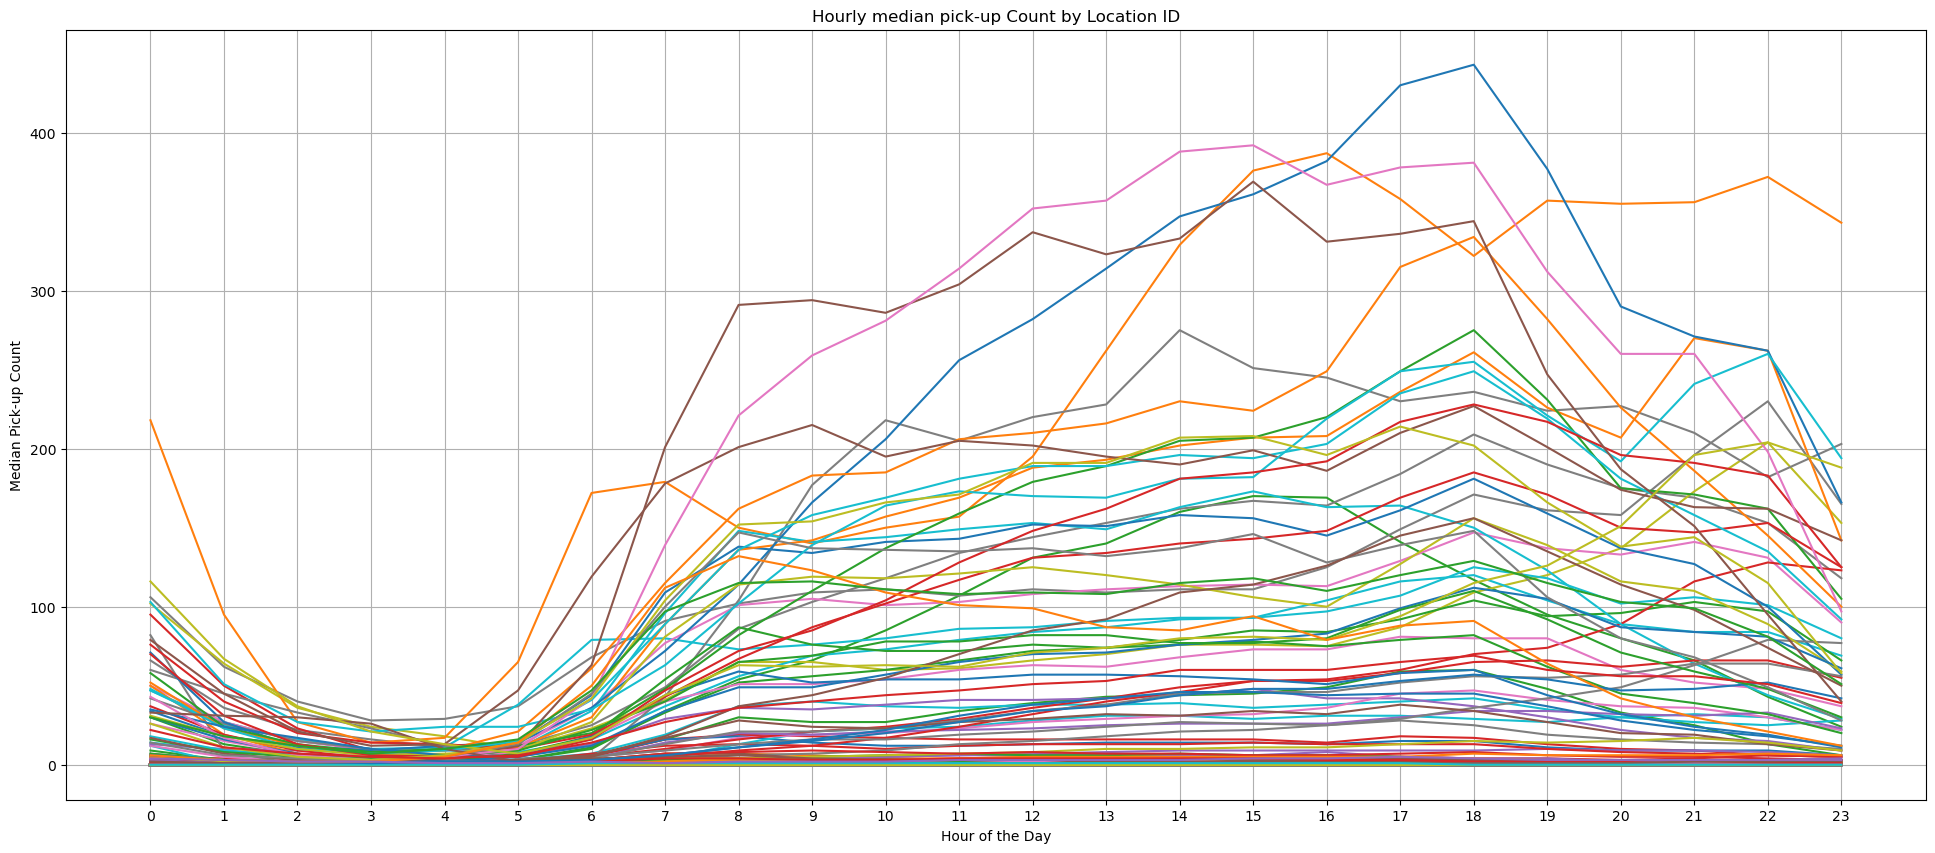

In [216]:
hourly_median_counts_by_location = trip_data.groupby(['PULocationID','hour'])['PU_count'].median()
hourly_median_counts_by_location.unstack().T.plot(kind='line', figsize=(24, 10), title='Hourly median pick-up Count by Location ID', grid=True,
                                                  xlabel='Hour of the Day', ylabel='Median Pick-up Count', legend=False, xticks=range(0,24,1))

Number of non-zero zones with median hourly median counts:  88


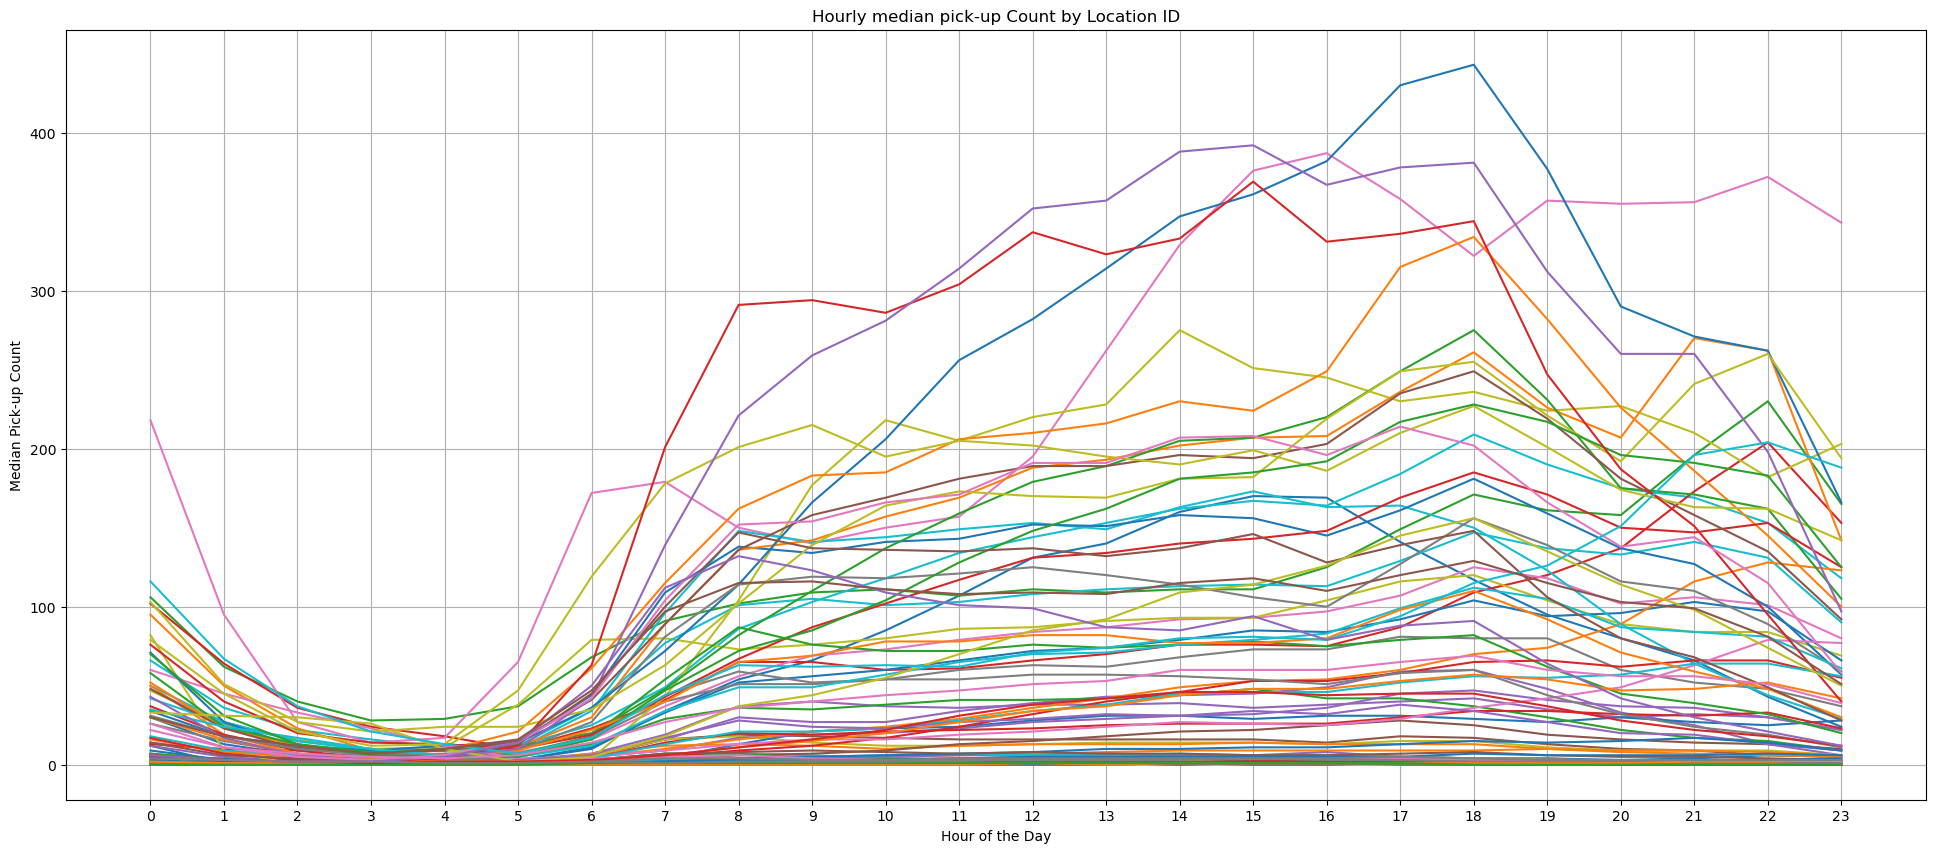

In [252]:
hourly_median_counts_by_location.unstack()[nonzero_zones_with_median_hourly_median_counts].T.plot(kind='line', 
                                                    figsize=(24, 10), title='Hourly median pick-up Count by Location ID', grid=True,
                                                    xlabel='Hour of the Day', ylabel='Median Pick-up Count', legend=False, xticks=range(0,24,1))

print("Number of non-zero zones with median hourly median counts: ", sum(nonzero_zones_with_median_hourly_median_counts))

Number of non-zero zones with median hourly median counts:  88


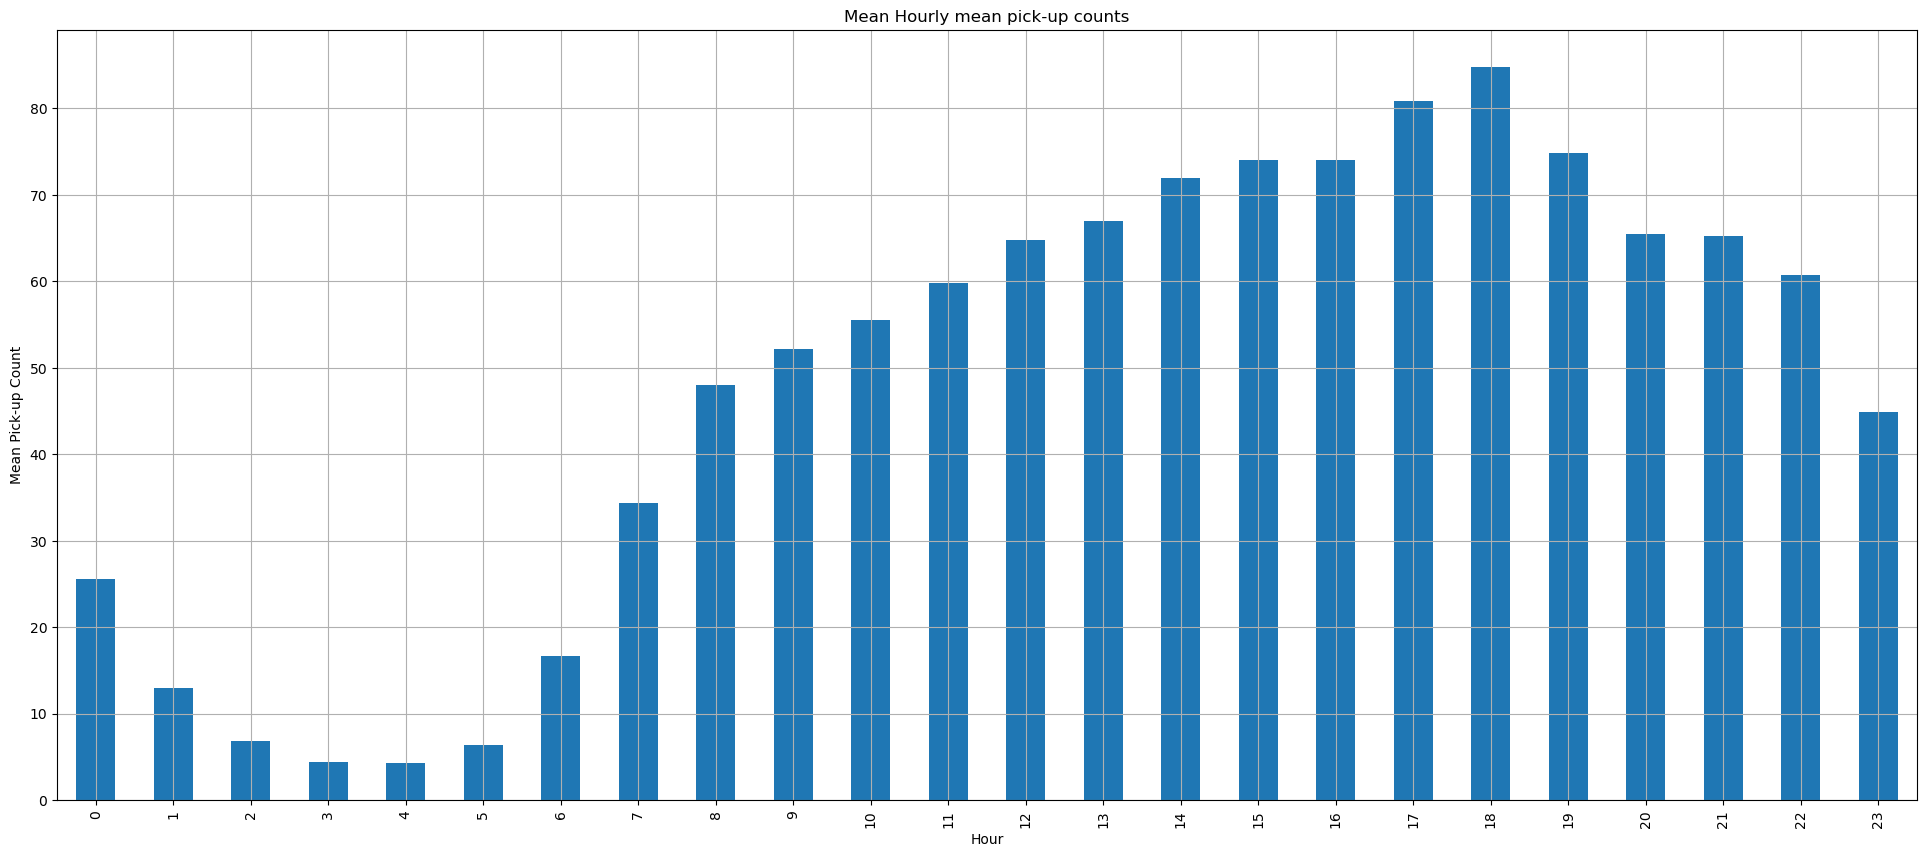

In [258]:
hourly_median_counts_by_location.unstack()[nonzero_zones_with_median_hourly_median_counts].mean().plot(kind='bar', 
                                                    figsize=(24, 10), title='Mean Hourly mean pick-up counts', grid=True,
                                                    xlabel='Hour', ylabel='Mean Pick-up Count', legend=False, xticks=range(0,24,1))

print("Number of non-zero zones with median hourly median counts: ", sum(nonzero_zones_with_median_hourly_median_counts))

Number of non-zero zones with median hourly median counts:  88


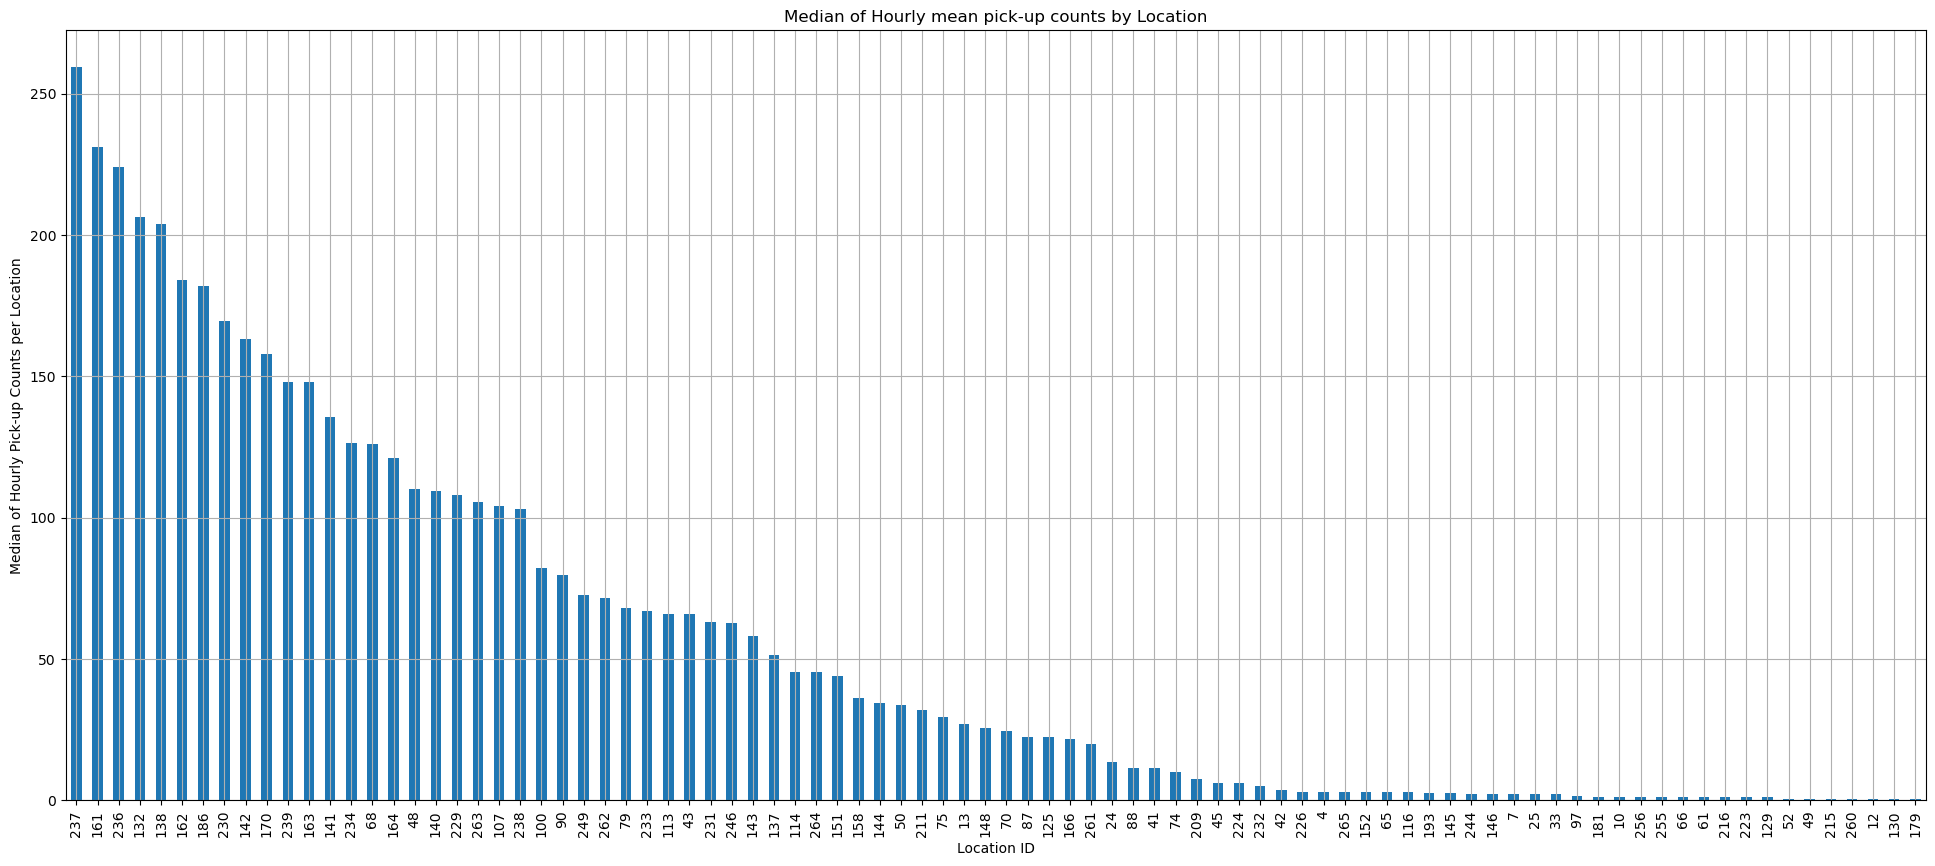

In [266]:
hourly_median_counts_by_location.unstack()[nonzero_zones_with_median_hourly_median_counts].T.median().sort_values(ascending=False).plot(kind='bar', 
                                                    figsize=(24, 10), title='Median of Hourly mean pick-up counts by Location', grid=True,
                                                    xlabel='Location ID', ylabel='Median of Hourly Pick-up Counts per Location', legend=False)

print("Number of non-zero zones with median hourly median counts: ", sum(nonzero_zones_with_median_hourly_median_counts))